In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from scipy import linalg
import sklearn.decomposition
import sklearn.discriminant_analysis
import sklearn.cluster
import sklearn.metrics.pairwise

In [2]:
train_data = np.genfromtxt('X_train.csv', delimiter=',')
train_label = np.genfromtxt('T_train.csv', delimiter=',')
test_data = np.genfromtxt('X_test.csv', delimiter=',')
test_label = np.genfromtxt('T_test.csv', delimiter=',')

In [3]:
train_data.shape, train_label.shape

((5000, 784), (5000,))

In [29]:
# some common function
def GetKeigen(eigen_values, eigen_vectors, k, isMin=True, startidx=1):
    sort_idxs = np.argsort(eigen_values)
    if not isMin:
        sort_idxs = np.flip(sort_idxs)
    return np.concatenate([
        eigen_vectors[:,sort_idxs[i]][:,None] 
        for i in range(startidx, startidx+k)
    ], axis=1)

def showEigen(eigen_values, eigen_vectors, isMin=True, show_number=6):
    # show eigen vector with min/max eigen value
    sort_idxs = np.argsort(eigen_values)
    if not isMin:
        sort_idxs = np.flip(sort_idxs)

    plt.plot(eigen_values[sort_idxs[:show_number]],'.')
    plt.xticks(range(show_number), sort_idxs[:show_number])
    plt.title('Eigen values')
    plt.xlabel('index of eigen vector')
    plt.show()

    plt.figure(figsize=(4*show_number,3))

    for i in range(show_number):
        plt.subplot(1, show_number, i+1)
        plt.plot(eigen_vectors[:,sort_idxs[i]])
        plt.title('Eigen vectors '+str(sort_idxs[i]))

    plt.show()
    
def showCluster(datas, labels, autoshow=True):
    for t in np.unique(labels):
        mask = labels == t
        plt.plot(datas[mask,0], datas[mask,1], '.', label='label '+str(t))
    
    plt.legend()
    if autoshow:
        plt.show()
        
def showFaces(faces, col=10):
    f = faces.reshape(-1,112,92)
    n = f.shape[0]
    all_faces = []
    for i in range(int(n/col)):
        all_faces += [np.concatenate(f[col*i:col*(i+1)], axis=1)]
    
    all_faces = np.concatenate(all_faces, axis=0)
    plt.figure(figsize=(4*(n/col),4*col))
    plt.imshow(all_faces, cmap='gray')
    plt.show()

# Kernels

- Linear

- Poly

- RBF

- Linear+RBF


In [5]:
def __Normal(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))

def Linear(u,v):
    return np.matmul(u, v.T);
    
def Poly(u,v, gamma, coef0, degree):
    return ((gamma*np.matmul(u, v.T)) + coef0)**degree
    
def Euclidean(x,y):
    """
    calculate Euclidean distance
    parameters:
        x: n1 * d, y: n2 x d
    return:
        d: n1 * n2
        
    d(i, j) = |x(i) - y(j)|^2
    """
    if len(x.shape)==1:
        x = x[None,:]
    if len(y.shape)==1:
        y = y[None,:]
    return np.matmul(x**2, np.ones((x.shape[1],y.shape[0]))) \
    + np.matmul(np.ones((x.shape[0],x.shape[1])), (y**2).T) \
    - 2*np.dot(x,y.T)

def RBF(u,v,gamma=1):
    return np.exp(-1*gamma*Euclidean(u,v));

def LinearKernel():
    return lambda u,v:Linear(u,v)

def PolyKernel(gamma=1, coef0=1, degree=3):
    return lambda u,v:Poly(u,v,gamma,coef0,degree)
    
def RBFKernel(gamma=1):
    """
    generate callable function for RBF kernel
    parameters:
        gamma : default is 1
    return:
        lambda(u, v)
        
    rbf(u, v) = exp(-gamma|u-v|^2)
    """
    return lambda u,v:RBF(u,v,gamma)

def LinearRBFKernel(gamma=1):
    return lambda u,v:__Normal(Linear(u,v)) + RBF(u,v,gamma)

# verify kernel impl (sklearn)

In [6]:
params = {
    "gamma" : 1/100,
    "coef0" : 1,
    "degree" : 3
}
__testkernels = {
    'linear' : LinearKernel(),
    'poly' : PolyKernel(params['gamma'], params['coef0'], params['degree']),
    'rbf' : RBFKernel(params['gamma'])
}


for ktype, kernel in __testkernels.items():
    result = np.allclose(
        sklearn.metrics.pairwise.pairwise_kernels(train_data, None, metric=ktype, filter_params=True, **params),
        kernel(train_data, train_data)
    )
    print("{} : {}".format(ktype, 'pass' if result else 'fail'))

linear : pass
poly : pass
rbf : pass


# Kernels with parameters

In [8]:
# parameters setting from HW5 grid search + cross-validation
__kernels = {
    'Linear' : LinearKernel(),
    'Poly' : PolyKernel(3/1000, 1, 10),
    'RBF' : RBFKernel(0.01), 
    'Linear+RBF' : LinearRBFKernel(0.01)
}

# PCA Principal Components Analysis

find a orthogonal projection $W$ has minimum MSE(mean square error)

$$ z = xW \\
MSE = ||x - zW^T||^2 = || x - xWW^T ||^2 \\
= \text{constant} - \text{constant}W^TSW, S_{i,j} = \frac{\sum_{k=1}^N (x_{k}(i) - \bar{x(i)})(x_{k}(j) - \bar{x(j)})^T}{N}, x = \left[ \begin{matrix} x(0) \\ x(1) \\ \vdots \\ x(d) \end{matrix} \right]$$

$W^TSW$ is covariance matrix, so we can maximize $W^TSW$ and get minimum MSE

It become a Rayleigh quotient problem, find eigen vector with max eigen value.

### kernel PCA

$$ \frac{(\phi(X) - \frac{ \sum_{i}^n \phi(Xi)}{N} )(\phi(X) - \frac{ \sum_{i}^n \phi(Xi)}{N})^T}{N} W = \lambda W , W = \phi(X)\alpha \\
\Rightarrow (K - 1_N K - K 1_N + 1_N K 1_N)\alpha = \lambda N\alpha
\\ z = \phi(x)W = \phi(x)\phi(X)\alpha = K(x,X)\alpha $$

In [9]:
def covariance(x, y):
    x1 = x - (np.sum(x, axis = 1) / x.shape[1])[:,None]
    y1 = y - (np.sum(y, axis = 1) / y.shape[1])[:,None]
    return np.matmul(x1, y1.T)/ x1.shape[1]

def PCA(datas, k, kernel=None):
    if callable(kernel):
        datas = kernel(datas, datas)
        N = datas.shape[0]
        N1 = np.ones((N,N))/N
        S = (datas 
             - np.matmul(N1, datas) 
             - np.matmul(datas, N1) 
             + np.matmul(np.matmul(N1, datas), N1)
            )/N
    else:
        S = covariance(datas.T, datas.T)
    
    value, vector = np.linalg.eigh(S)
    
    #showEigen(value, vector, isMin=False)
    
    start_idxs = 0 if callable(kernel) else 0
    max_idxs = np.flip(np.argsort(value))
    W = np.concatenate([
        vector[:, max_idxs[i]][:,None] 
        for i in range(start_idxs,k+start_idxs)
    ], axis=1)
    
    # whitening
    if callable(kernel):
        W /= np.sqrt(value[max_idxs[start_idxs:start_idxs+k]])[None, :]
    
    return np.matmul(datas, W), W, value, vector

np.allclose(np.cov(train_data.T, bias=1), covariance(train_data.T, train_data.T))
#np.allclose(sklearn.discriminant_analysis._cov(train_data), covariance(train_data.T, train_data.T))

True

In [10]:
# parameter
dim = 2
S = covariance(train_data.T, train_data.T)
S.shape

(784, 784)

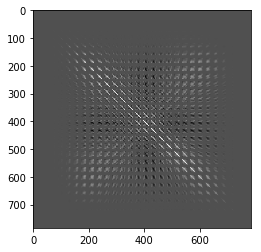

In [11]:
plt.imshow(S, cmap='gray')

In [12]:
%%time
eigen_values, eigen_vectors = np.linalg.eigh(S)

CPU times: user 1.06 s, sys: 1.02 s, total: 2.09 s
Wall time: 499 ms


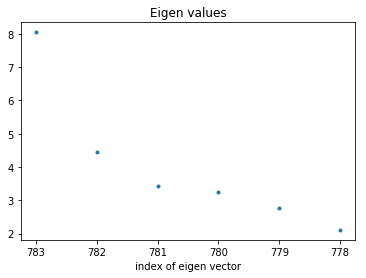

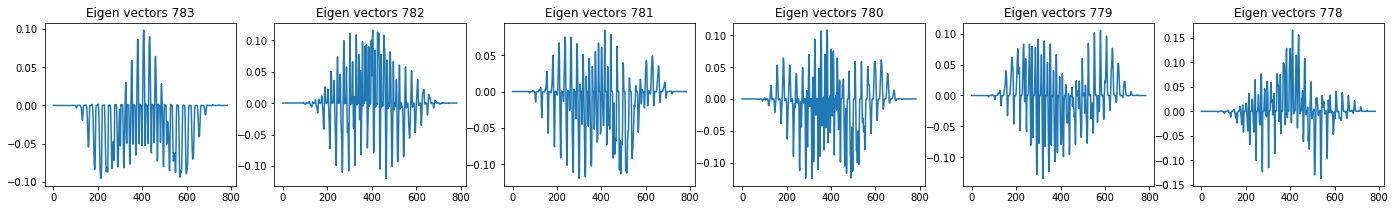

In [13]:
# show eigen vector with max eigen value
showEigen(eigen_values, eigen_vectors, isMin=False)

In [14]:
max_idxs = np.flip(np.argsort(eigen_values))
W = np.concatenate([eigen_vectors[:, max_idxs[i]][:,None] for i in range(0,dim+0)], axis=1)
W.shape    

(784, 2)

In [15]:
PCA_space = np.matmul(train_data, W)
PCA_space.shape

(5000, 2)

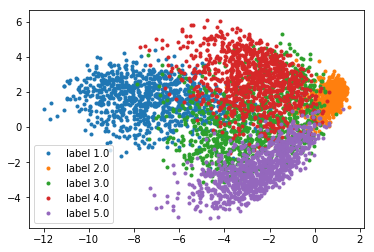

In [16]:
showCluster(PCA_space, train_label)

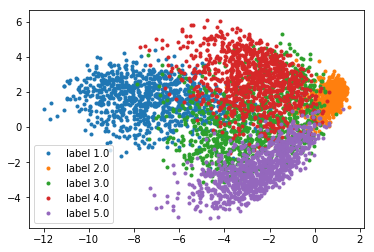

In [17]:
# test function
showCluster(PCA(train_data, 2)[0], train_label)

In [18]:
__kPCA_space = {}

In [19]:
%%time
for kernelname, kernel in __kernels.items():
    if not kernelname in __kPCA_space:
        __kPCA_space[kernelname] = PCA(train_data, 2, kernel=kernel)[0]

CPU times: user 33min 17s, sys: 5min 10s, total: 38min 28s
Wall time: 5min 33s


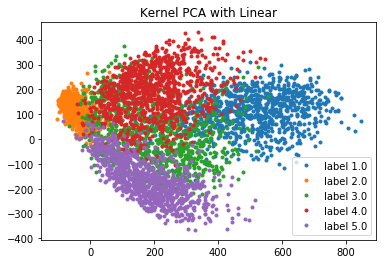

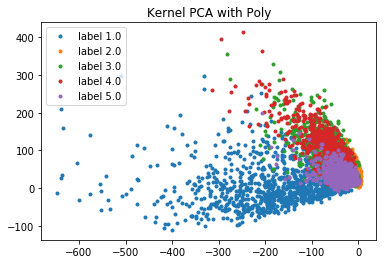

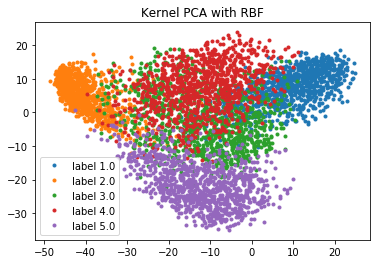

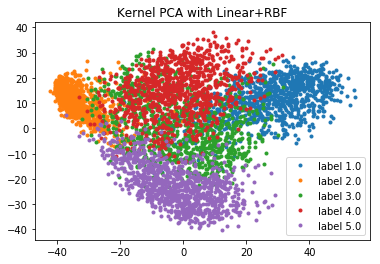

In [20]:
for kernelname, kpca_spcae in __kPCA_space.items():
    plt.title('Kernel PCA with {}'.format(kernelname))
    showCluster(kpca_spcae, train_label)

# PCA reference answer (sklearn)

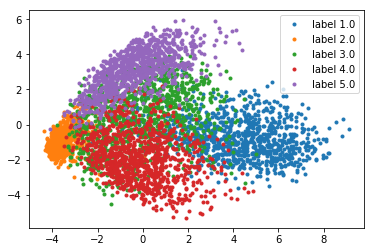

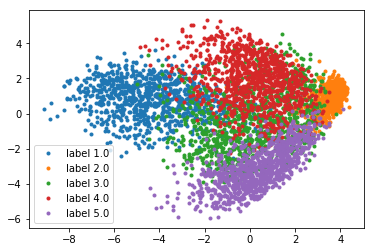

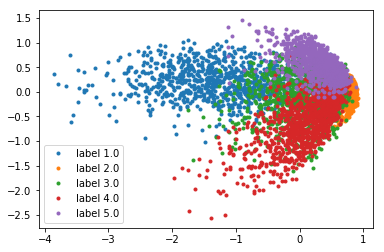

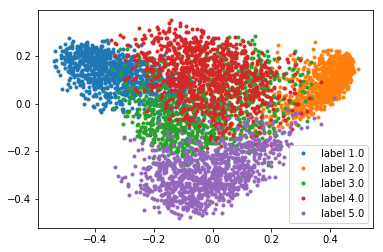

In [21]:
# PCA
showCluster(sklearn.decomposition.PCA(n_components=2).fit_transform(train_data), train_label)
# kernel PCA linear
showCluster(sklearn.decomposition.KernelPCA(n_components=2).fit_transform(train_data), train_label)
# kernel PCA poly
showCluster(sklearn.decomposition.KernelPCA(
    n_components=2, kernel='poly', gamma=1/100, coef0 = 1, degree = 3 
).fit_transform(train_data), train_label)
# kernel PCA rbf
showCluster(sklearn.decomposition.KernelPCA(
    n_components=2, kernel='rbf', gamma=1/100 
).fit_transform(train_data), train_label)

# LDA Linear Discriminative Analysis

- has $k$ classes
- maximize between-class-scatter $S_B = \sum_{j=1}^k |C_j|(m_j - m)(m_j - m)^T, m = \frac{\sum x}{n}, m_j = \frac{\sum_{x_i \in C_j} x_i}{|C_j|}$
- minimize within-class-scatter  $S_W = \sum_{j=1}^k \sum_{x_i \in C_j} (x_i - m_j)(x_i - m_j)^T$
- solve eigen problem $ S_B W = \lambda S_W W  \Rightarrow S_W^{-1} S_B W = \lambda W$

## kernel LDA

$$ S_B^\phi = \sum_{j=1}^k |C_j|(m_j^\phi - m^\phi)(m_j^\phi - m^\phi)^T, m_j^\phi = \frac{\sum_{x_i \in C_j} \phi(x_i)}{|C_j|} \\
S_W^\phi = \sum_{j=1}^k \sum_{x_i \in C_j} (\phi(x_i) - m_j^\phi)(\phi(x_i) - m_j^\phi)^T \\
W = \sum_i^w \sum_j^n W_{i,j}\phi(x_j) \\
\frac{W^T S_B^\phi W}{W^T S_W^\phi W} = \frac{\alpha^T M \alpha}{\alpha^T N \alpha} \\
M = \sum_{j=1}^k |C_J|(M_j - M_{all})(M_j - M_{all})^T, M_j =  \frac{\sum_{x_i \in C_j} \sum_{x_j}^n K(x_i, x_j)}{|C_j|} \\
N = \sum_{j=1}^k K_j(I - 1_{|C_j|})K_j^T \\
$$ 

[kernel LDA from wiki](https://en.wikipedia.org/wiki/Kernel_Fisher_discriminant_analysis)

In [22]:
def LDA(datas, labels, k, kernel=None):
    C = np.zeros((datas.shape[0], len(np.unique(labels))))
    for idx, j in enumerate(np.unique(labels)):
        C[labels == j,idx] = 1;
    
    Mj = np.matmul(datas.T, C) / np.sum(C, axis = 0)
    M = np.sum(datas.T, axis = 1) / datas.shape[0]
    
    B = Mj - M[:,None]    
    SB = np.matmul(B * np.sum(C, axis = 0), B.T) 
    
    W = datas.T - np.matmul(Mj, C.T)
    SW = np.zeros(SB.shape)
    for group in np.unique(train_label):
        w = W[:, train_label == group]
        SW += np.matmul(w, w.T) / w.shape[1]
    
    try:
        SW_inv = np.linalg.inv(SW)
    except:
        SW_inv = np.linalg.pinv(SW)
    
    SBW = np.matmul(SW_inv, SB)
    value, vector = np.linalg.eigh(SBW)
    
    start_idx = 0
    max_idxs = np.flip(np.argsort(value))
    W = np.concatenate([
        vector[:, max_idxs[i]][:,None] 
        for i in range(start_idx,start_idx+k)
    ], axis=1)
    
    return np.matmul(datas, W), W

In [23]:
# parameter
dim = 2
C = np.zeros((train_data.shape[0], len(np.unique(train_label))))

for idx, j in enumerate(np.unique(train_label)):
    C[train_label == j,idx] = 1;

Mj = np.matmul(train_data.T, C) / np.sum(C, axis = 0)
M = np.sum(train_data.T, axis = 1) / train_data.shape[0]
B = Mj - M[:,None]    
SB = np.matmul(B * np.sum(C, axis = 0), B.T) 

W = train_data.T - np.matmul(Mj, C.T)

SW = np.zeros(SB.shape)
for group in np.unique(train_label):
    w = W[:, train_label == group]
    SW += np.matmul(w, w.T) / w.shape[1]

SBW = np.matmul(np.linalg.pinv(SW), SB)
SBW.shape

SB.shape, SW.shape, SBW.shape

((784, 784), (784, 784), (784, 784))

In [24]:
%%time
eigen_values, eigen_vectors = np.linalg.eigh(SBW)

CPU times: user 1.01 s, sys: 649 ms, total: 1.66 s
Wall time: 251 ms


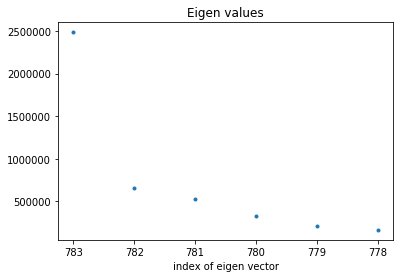

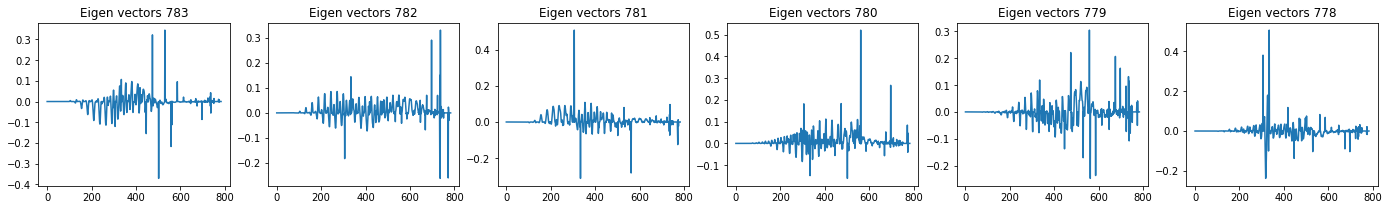

In [25]:
# show eigen vector with max eigen value
showEigen(eigen_values, eigen_vectors, isMin=False)

In [30]:
W = GetKeigen(eigen_values, eigen_vectors, 2, isMin=False, startidx=0)
W.shape

(784, 2)

In [31]:
LDA_space = np.matmul(train_data, W)
LDA_space.shape

(5000, 2)

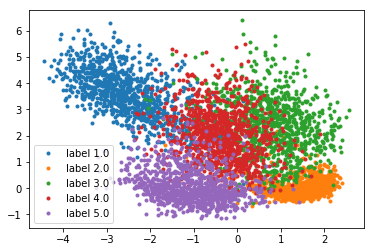

In [32]:
showCluster(LDA_space, train_label)

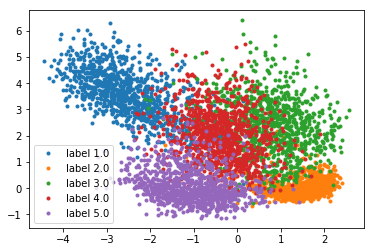

In [33]:
# test function
showCluster(LDA(train_data, train_label, 2)[0], train_label)

# LDA reference answer (sklearn)

/home/grass0756110/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


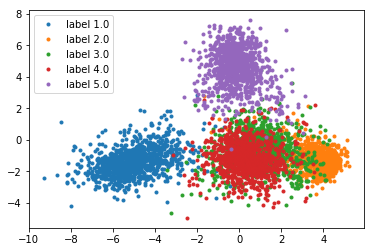

In [34]:
# LDA
showCluster(sklearn.discriminant_analysis.LinearDiscriminantAnalysis(
    n_components=2, 
    #solver='eigen',
    store_covariance=True
).fit_transform(train_data, train_label), train_label)

In [35]:
# verify
np.allclose(sklearn.discriminant_analysis._class_cov(train_data, train_label, priors=np.ones((5))), SW)

False

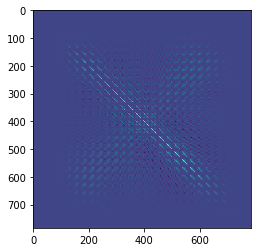

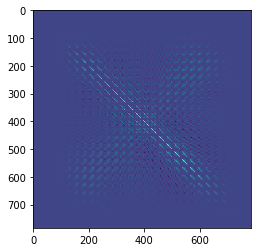

In [36]:
plt.imshow(sklearn.discriminant_analysis._class_cov(train_data, train_label, priors=np.ones((5))))
plt.show()
plt.imshow(SW)

In [37]:
np.allclose(sklearn.discriminant_analysis._class_means(train_data, train_label), Mj.T)

True

# RatioCut and NormalizedCut

- SimpleCut
    - $ \Rightarrow L = D - W $
- RatioCut
    - $ \Rightarrow L_R = \frac{D-W}{|V|}$
- NormalizedCut
    - $ \Rightarrow L_N = D^{-\frac{1}{2}}LD^{-\frac{1}{2}} $
- GeneralizeCut
    - $ \Rightarrow L_G = D^{-1}L $

In [38]:
def KernelTrick(gram_m, c):
    """
    calculate Euclidean distance in feature space by kernel trick
    parameters:
        gram_m : gram matrix K(x, x)
        c : cluster vector c(i,k) = 1 if x(i) belong k clustering
    return:
        w : n*k
    """
    return (
        np.matmul(
        gram_m * np.eye(gram_m.shape[0]), 
        np.ones((gram_m.shape[0], c.shape[1])) 
    ) \
    - 2*( np.matmul(gram_m, c) / np.sum(c, axis=0) ) \
    + (np.matmul(
        np.ones((gram_m.shape[0], c.shape[1])), 
        np.matmul(np.matmul(c.T, gram_m), c)*np.eye(c.shape[1])
    ) / (np.sum(c,axis=0)**2) )
    )

def RandomCluster(n,k):
    """
    get random cluster c
    """
    c = np.zeros((n,k))
    c[np.arange(n),np.random.randint(k,size=n)] = 1             
    return c

def RandomMean(k,dim):
    """
    get random mean
    """
    return -1 + 2*np.random.random((k,dim))

def GetMeanFromCluster(datas, c):
    """
    get mean from cluster c
    """
    if np.count_nonzero(np.sum(c, axis=0) == 0):
        raise ArithmeticError
    return np.matmul(c.T, datas) / np.sum(c, axis=0)[:,None]

def GetCluster(w):
    """
    get cluster from w (distance between x and u)
    """
    new_c = np.zeros(w.shape)
    new_c[np.arange(w.shape[0]),np.argmin(w, axis=1)] = 1
    return new_c

def kmeans(datas, k, 
           initial_u=None, 
           initial_c=None,
           isKernel=False, 
           converge_count = 1
          ):
    """
    use generator to iter steps
    parameters:
        datas : data points
        k : how many cluster
        initial_u : assign mean u
        initial_c : assign cluster c
        isKernel : use kernel k-means (default is False)
    return:
        python generator
        
    next() will get cluster c and mean u
    e.g.
        c, u = next(g)
    if converge, next() will raise Error
    """
    
    # initialization
    if isKernel:
        gram_matrix = datas
        c = initial_c if type(initial_c)!=type(None) \
            else RandomCluster(datas.shape[0], k)
    else:
        u = initial_u if type(initial_u)!=type(None) \
            else RandomMean(k,datas.shape[1])
        c = np.zeros((datas.shape[0],k))
    
    while(1):
        # E-step
        if not isKernel:
            w = Euclidean(datas, u)
        else:
            w = KernelTrick(gram_matrix, c)

        # M-step
        update_c = np.zeros(w.shape)
        update_c[np.arange(w.shape[0]),np.argmin(w, axis=1)] = 1
    
        delta_c = np.count_nonzero(np.abs(update_c - c))
        if not isKernel:
            u = GetMeanFromCluster(datas, update_c)
        else:
            u = None
        
        yield update_c, u
        
        if delta_c == 0:
            converge_count-=1
            # find converge
            if converge_count == 0:
                break
        
        c = update_c
    
    return

In [39]:
def __normalizecut(W,D):
    d = np.sqrt(np.linalg.inv(D))
    return np.matmul(np.matmul(d, D-W), d)

def __generalizecut(W,D):
    return np.matmul(np.linalg.inv(D), D-W)

__spectral_cut = {
    0 : lambda W,D:D-W,
    1 : lambda W,D:(D-W)/D.shape[0],
    2 : __normalizecut,
    3 : __generalizecut,
}
def Spectral(datas, kernel, k=None, cutType=0):
    """
    spectral clustering
    parameters:
        datas : data source n*d
        kernel : function for compute kernel
        k : mapping data to k-dim eigen space
        cutType:
            - 0 : simple cut, D-W
            - 1 : ratio cut, (D-W)/|V|
            - 2 : normalize cut, D^-1/2(D-W)D^-1/2
            - 3 : generalize cut, D^-1(D-W)
    return:
        U : data in eigen space n*k
        eigen values : n*1
        eigen vector : n*n
    """
    if not callable(kernel):
        raise AttributeError;
    W = kernel(datas, datas)
    D = np.sum(W, axis=1)*np.eye(W.shape[0])
    
    if not cutType in __spectral_cut:
        raise AttributeError;
    L = __spectral_cut[cutType](W,D)    
    
    eig_values, eig_vectors = np.linalg.eigh(L)
    
    return eig_values, eig_vectors

# minimize cut
#min_idxs = np.argsort(eig_values)
    
#U = np.concatenate([eig_vectors[:,min_idxs[i]][:,None] for i in range(k)], axis=1)
    
#if __spectral_cut[cutType] == __normalizecut:
#    U = U / np.sqrt(np.sum(U**2, axis=1))[:,None]

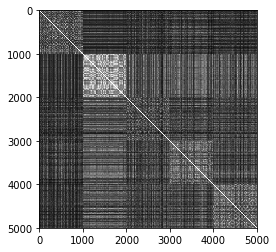

In [40]:
plt.imshow(RBFKernel(1/100)(train_data, train_data), cmap='gray')

In [41]:
%%time
eigen_values, eigen_vectors = Spectral(train_data, RBFKernel(1/100), 2, cutType=2)

CPU times: user 7min 36s, sys: 1min 36s, total: 9min 12s
Wall time: 1min 25s


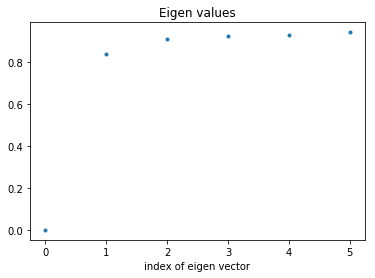

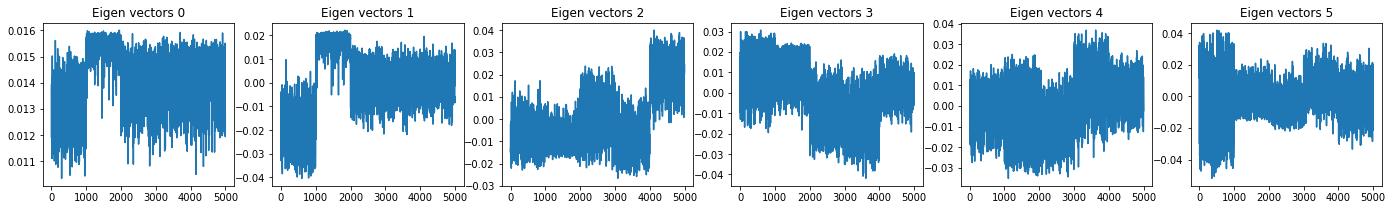

In [42]:
showEigen(eigen_values, eigen_vectors, show_number=6)

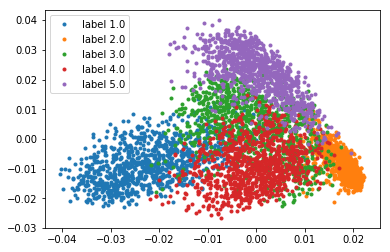

In [43]:
showCluster(GetKeigen(eigen_values, eigen_vectors, 2), train_label)

In [44]:
eigen_space = GetKeigen(eigen_values, eigen_vectors, 5)

In [45]:
launcher = kmeans(
    eigen_space, 
    k=5, 
    initial_u=GetMeanFromCluster(
        eigen_space, 
        RandomCluster(eigen_space.shape[0], 5)
    )
)
labels = list(launcher)[-1][0]
labels = np.where(labels == 1)[1]
#acc = np.count_nonzero((labels + 1) == train_label)/train_label.shape[0]
#'Accuracy {}%'.format(acc*100)

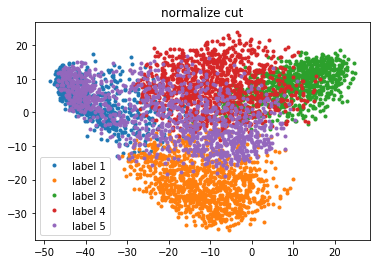

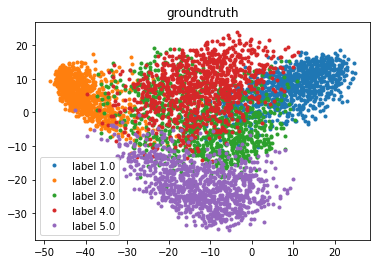

In [48]:
plt.title('normalize cut')
showCluster(__kPCA_space['RBF'], labels + 1)
plt.title('groundtruth')
showCluster(__kPCA_space['RBF'], train_label)

In [51]:
__cut_types = {
    'RatioCut' : 1,
    'NormalizedCut' : 2
}
__cut_eigens = {}
__cut_labels = {}

In [52]:
%%time
# run four kernels for two cut types
for kernelname, kernel in __kernels.items():
    for cutname, cut in __cut_types.items():
        eig_val, eig_vec = Spectral(train_data, kernel, cutType=cut)
        if not kernelname in __cut_eigens:
            __cut_eigens[kernelname] = {}
        if not cutname in __cut_eigens[kernelname]:
            __cut_eigens[kernelname][cutname] = [eig_val, eig_vec]

CPU times: user 48min 37s, sys: 8min, total: 56min 38s
Wall time: 8min 14s


In [53]:
# get clusters from eigen space
kmeank = 5
eigk = 5
for kernelname in __kernels.keys():
    for cutname in __cut_types.keys():
        if not kernelname in __cut_labels:
            __cut_labels[kernelname] = {}
        if not cutname in __cut_labels[kernelname]:
            eigs = __cut_eigens[kernelname][cutname]
            eigen_space = GetKeigen(eigs[0], eigs[1], eigk)
            launcher = kmeans(
                eigen_space, 
                k=kmeank, 
                initial_u=GetMeanFromCluster(
                    eigen_space, 
                    RandomCluster(eigen_space.shape[0], kmeank)
                )
            )
            labels = list(launcher)[-1][0]
            labels = np.where(labels == 1)[1]
            __cut_labels[kernelname][cutname] = labels

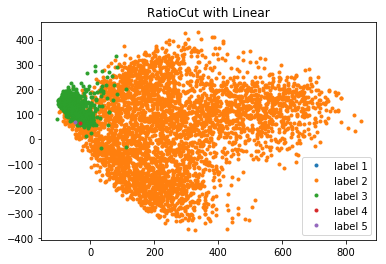

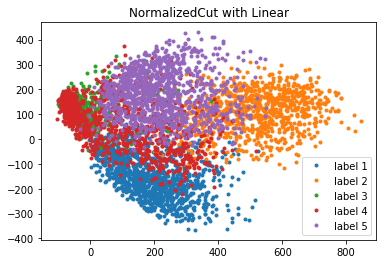

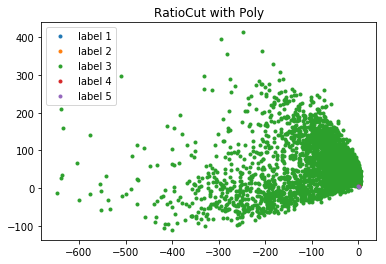

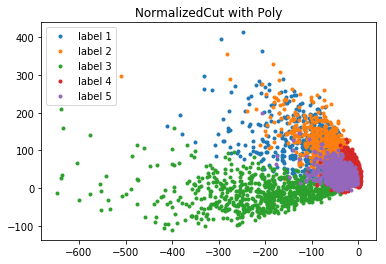

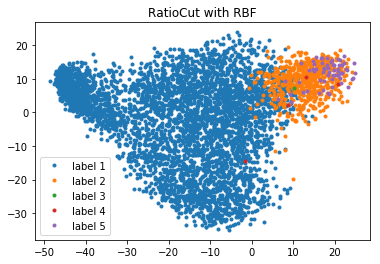

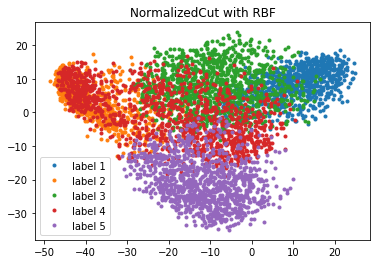

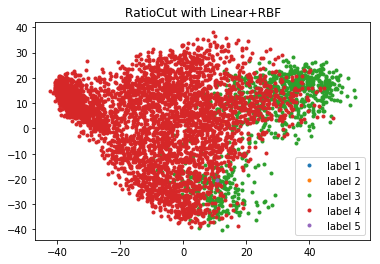

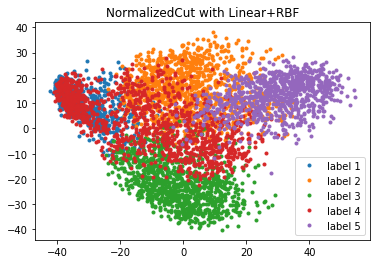

In [54]:
# draw figures
for kernelname in __kernels.keys():
    for cutname in __cut_types.keys():
        plt.title('{} with {}'.format(cutname, kernelname))
        showCluster(__kPCA_space[kernelname], __cut_labels[kernelname][cutname] + 1)

# Spectral cut reference answer

In [49]:
__ref_labels = sklearn.cluster.SpectralClustering(gamma=1/100, n_clusters=5).fit(train_data).labels_

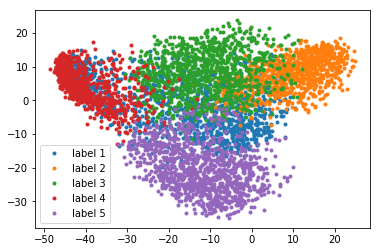

In [50]:
showCluster(__kPCA_space['RBF'], __ref_labels + 1)

# Eigen faces

In [565]:
import PIL.Image
att_faces_data = []
for i in range(1,41):
    for j in range(1,11):
        with PIL.Image.open(
            './att_faces/s{}/{}.pgm'.format(i, j)
        ) as im:
            att_faces_data += [np.array(im).reshape(1,-1)]
            
att_faces_data = np.concatenate(att_faces_data, axis = 0)
att_faces_data.shape

(400, 10304)

In [164]:
from IPython import display

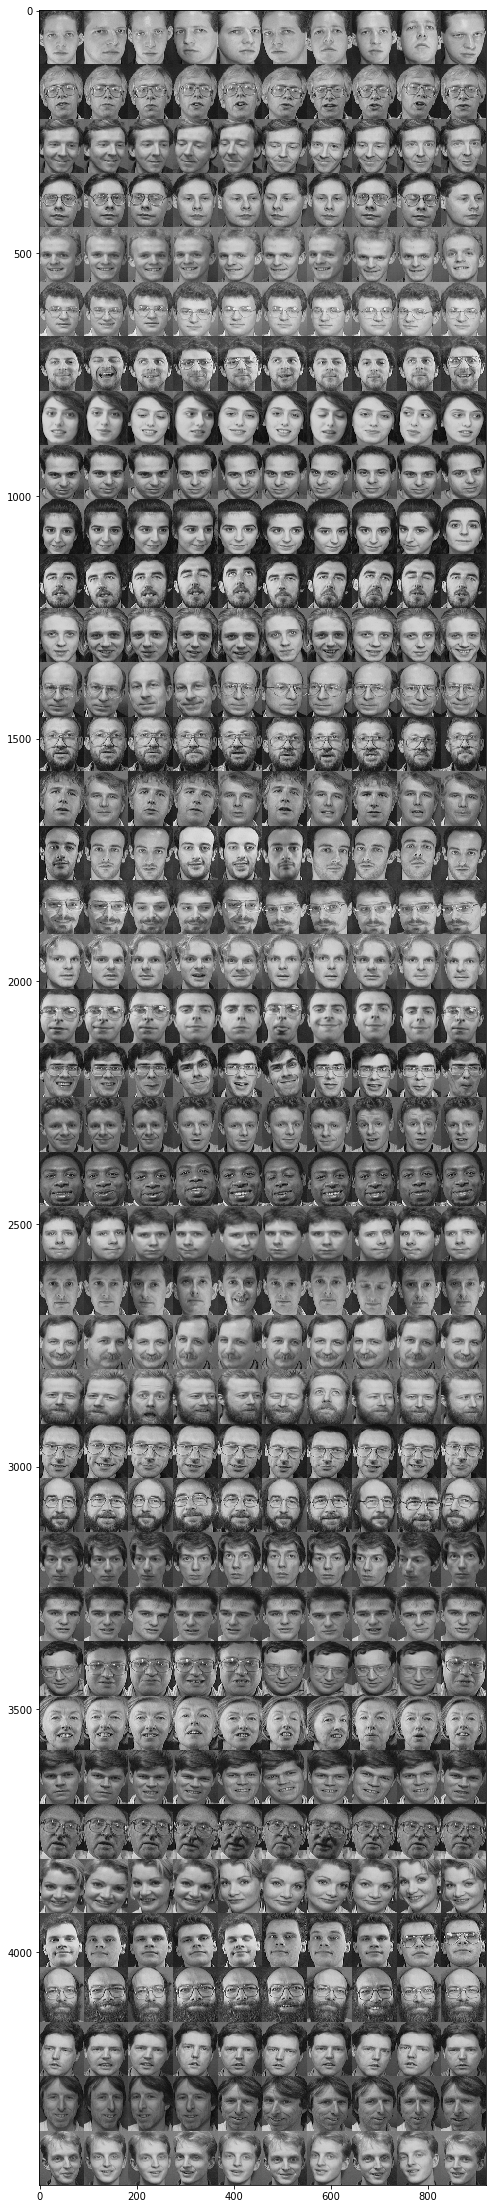

In [581]:
showFaces(att_faces_data)

In [568]:
%%time
face_pcaspace, face_eigen, face_eva, face_evc = PCA(att_faces_data, 25)

In [569]:
face_eigen.shape

(10304, 25)

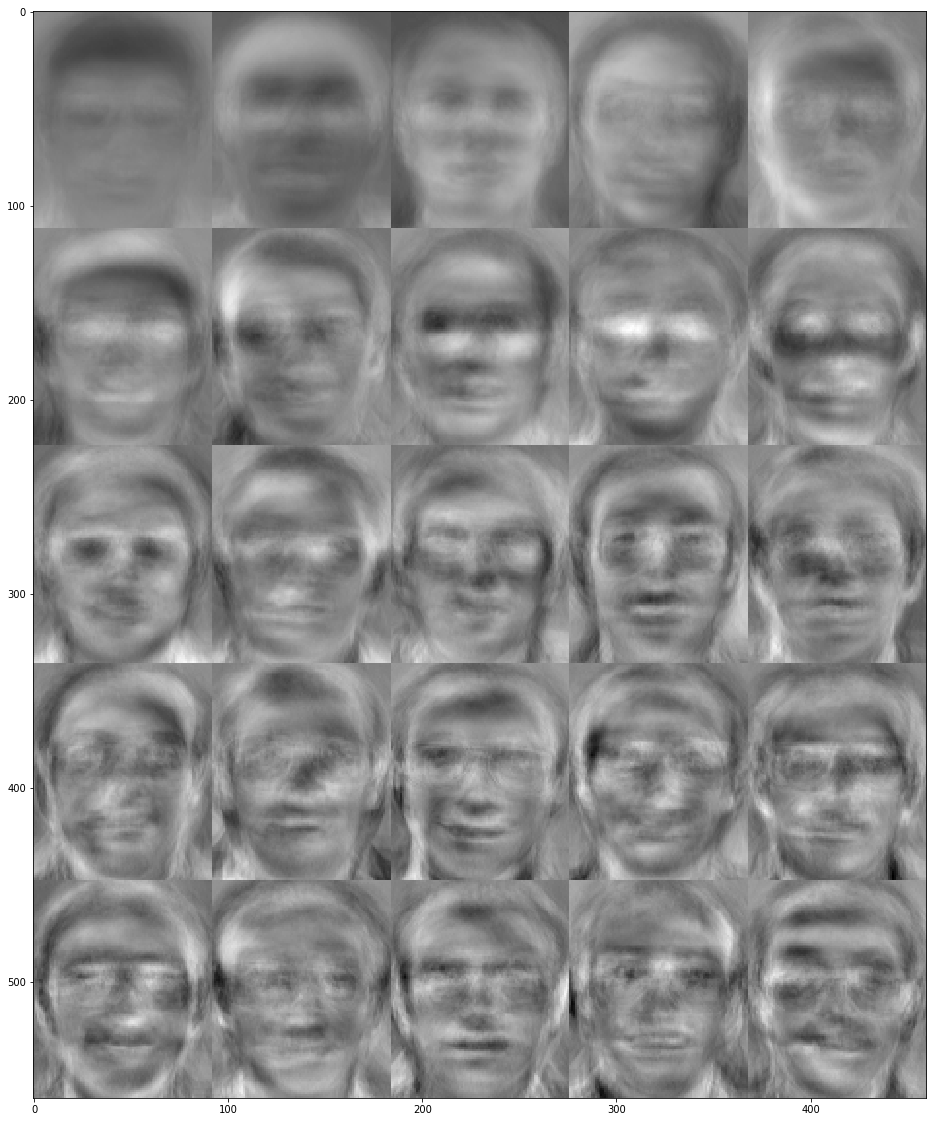

In [584]:
showFaces(face_eigen.T, col=5)

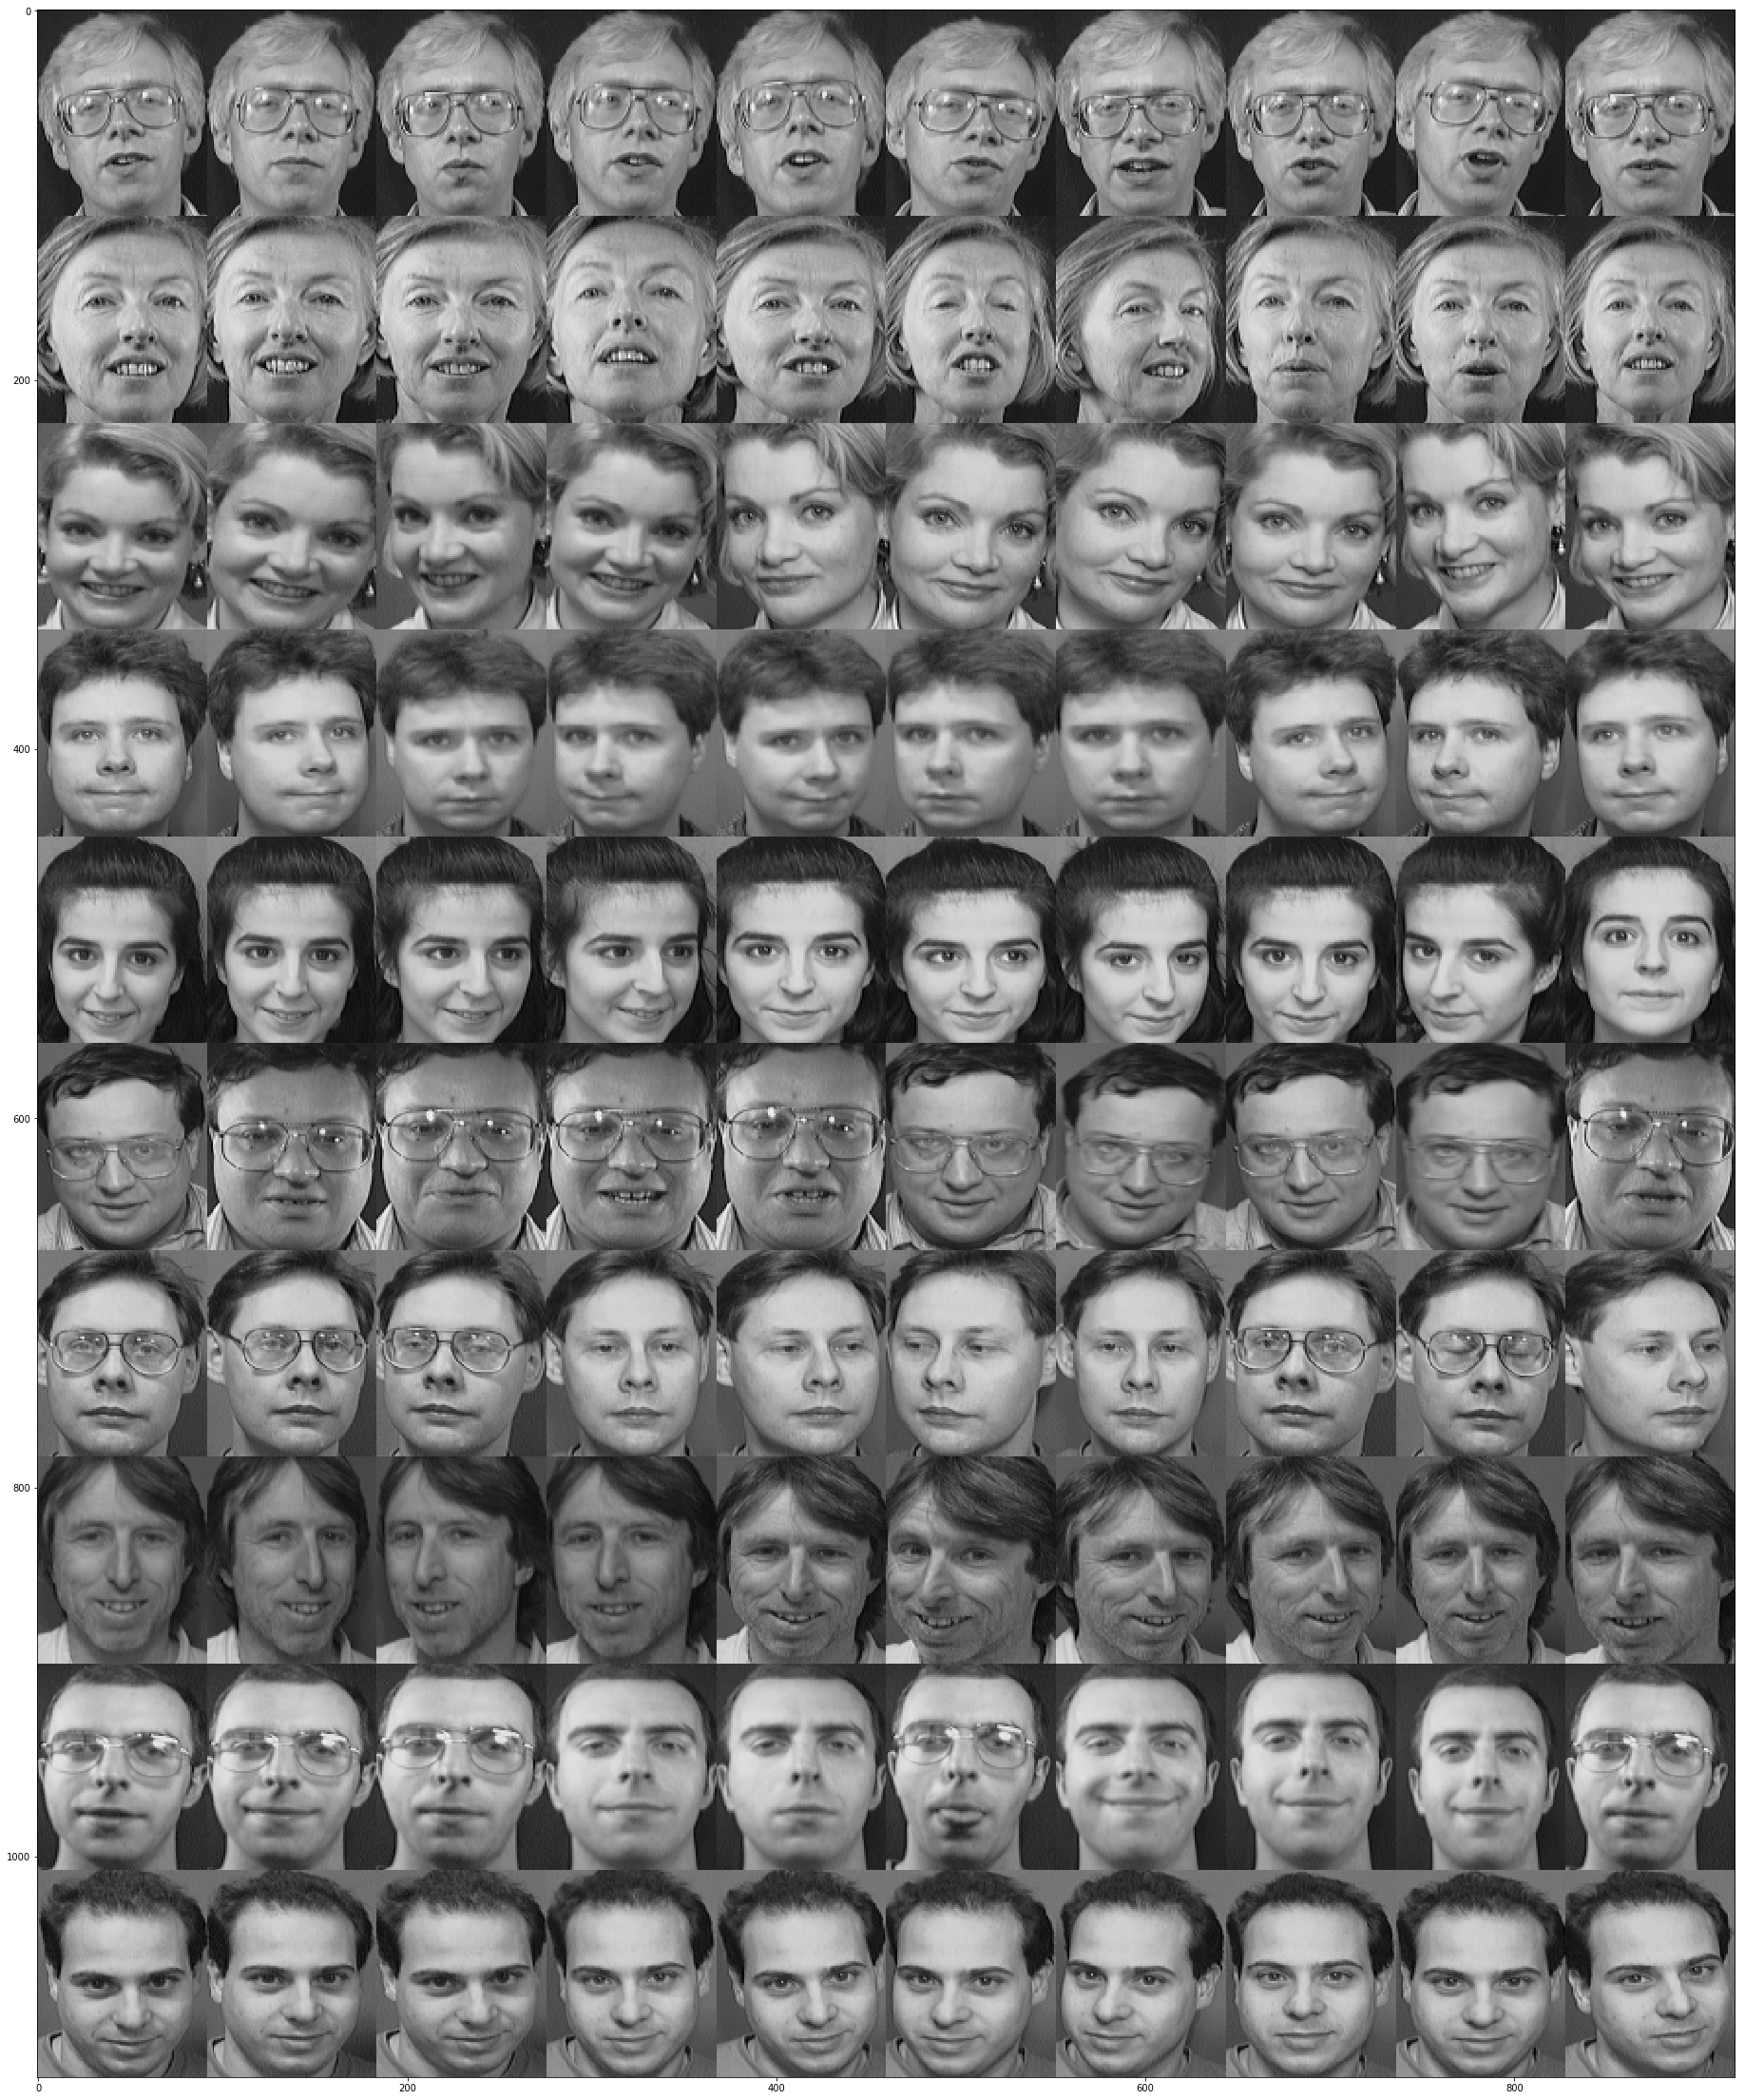

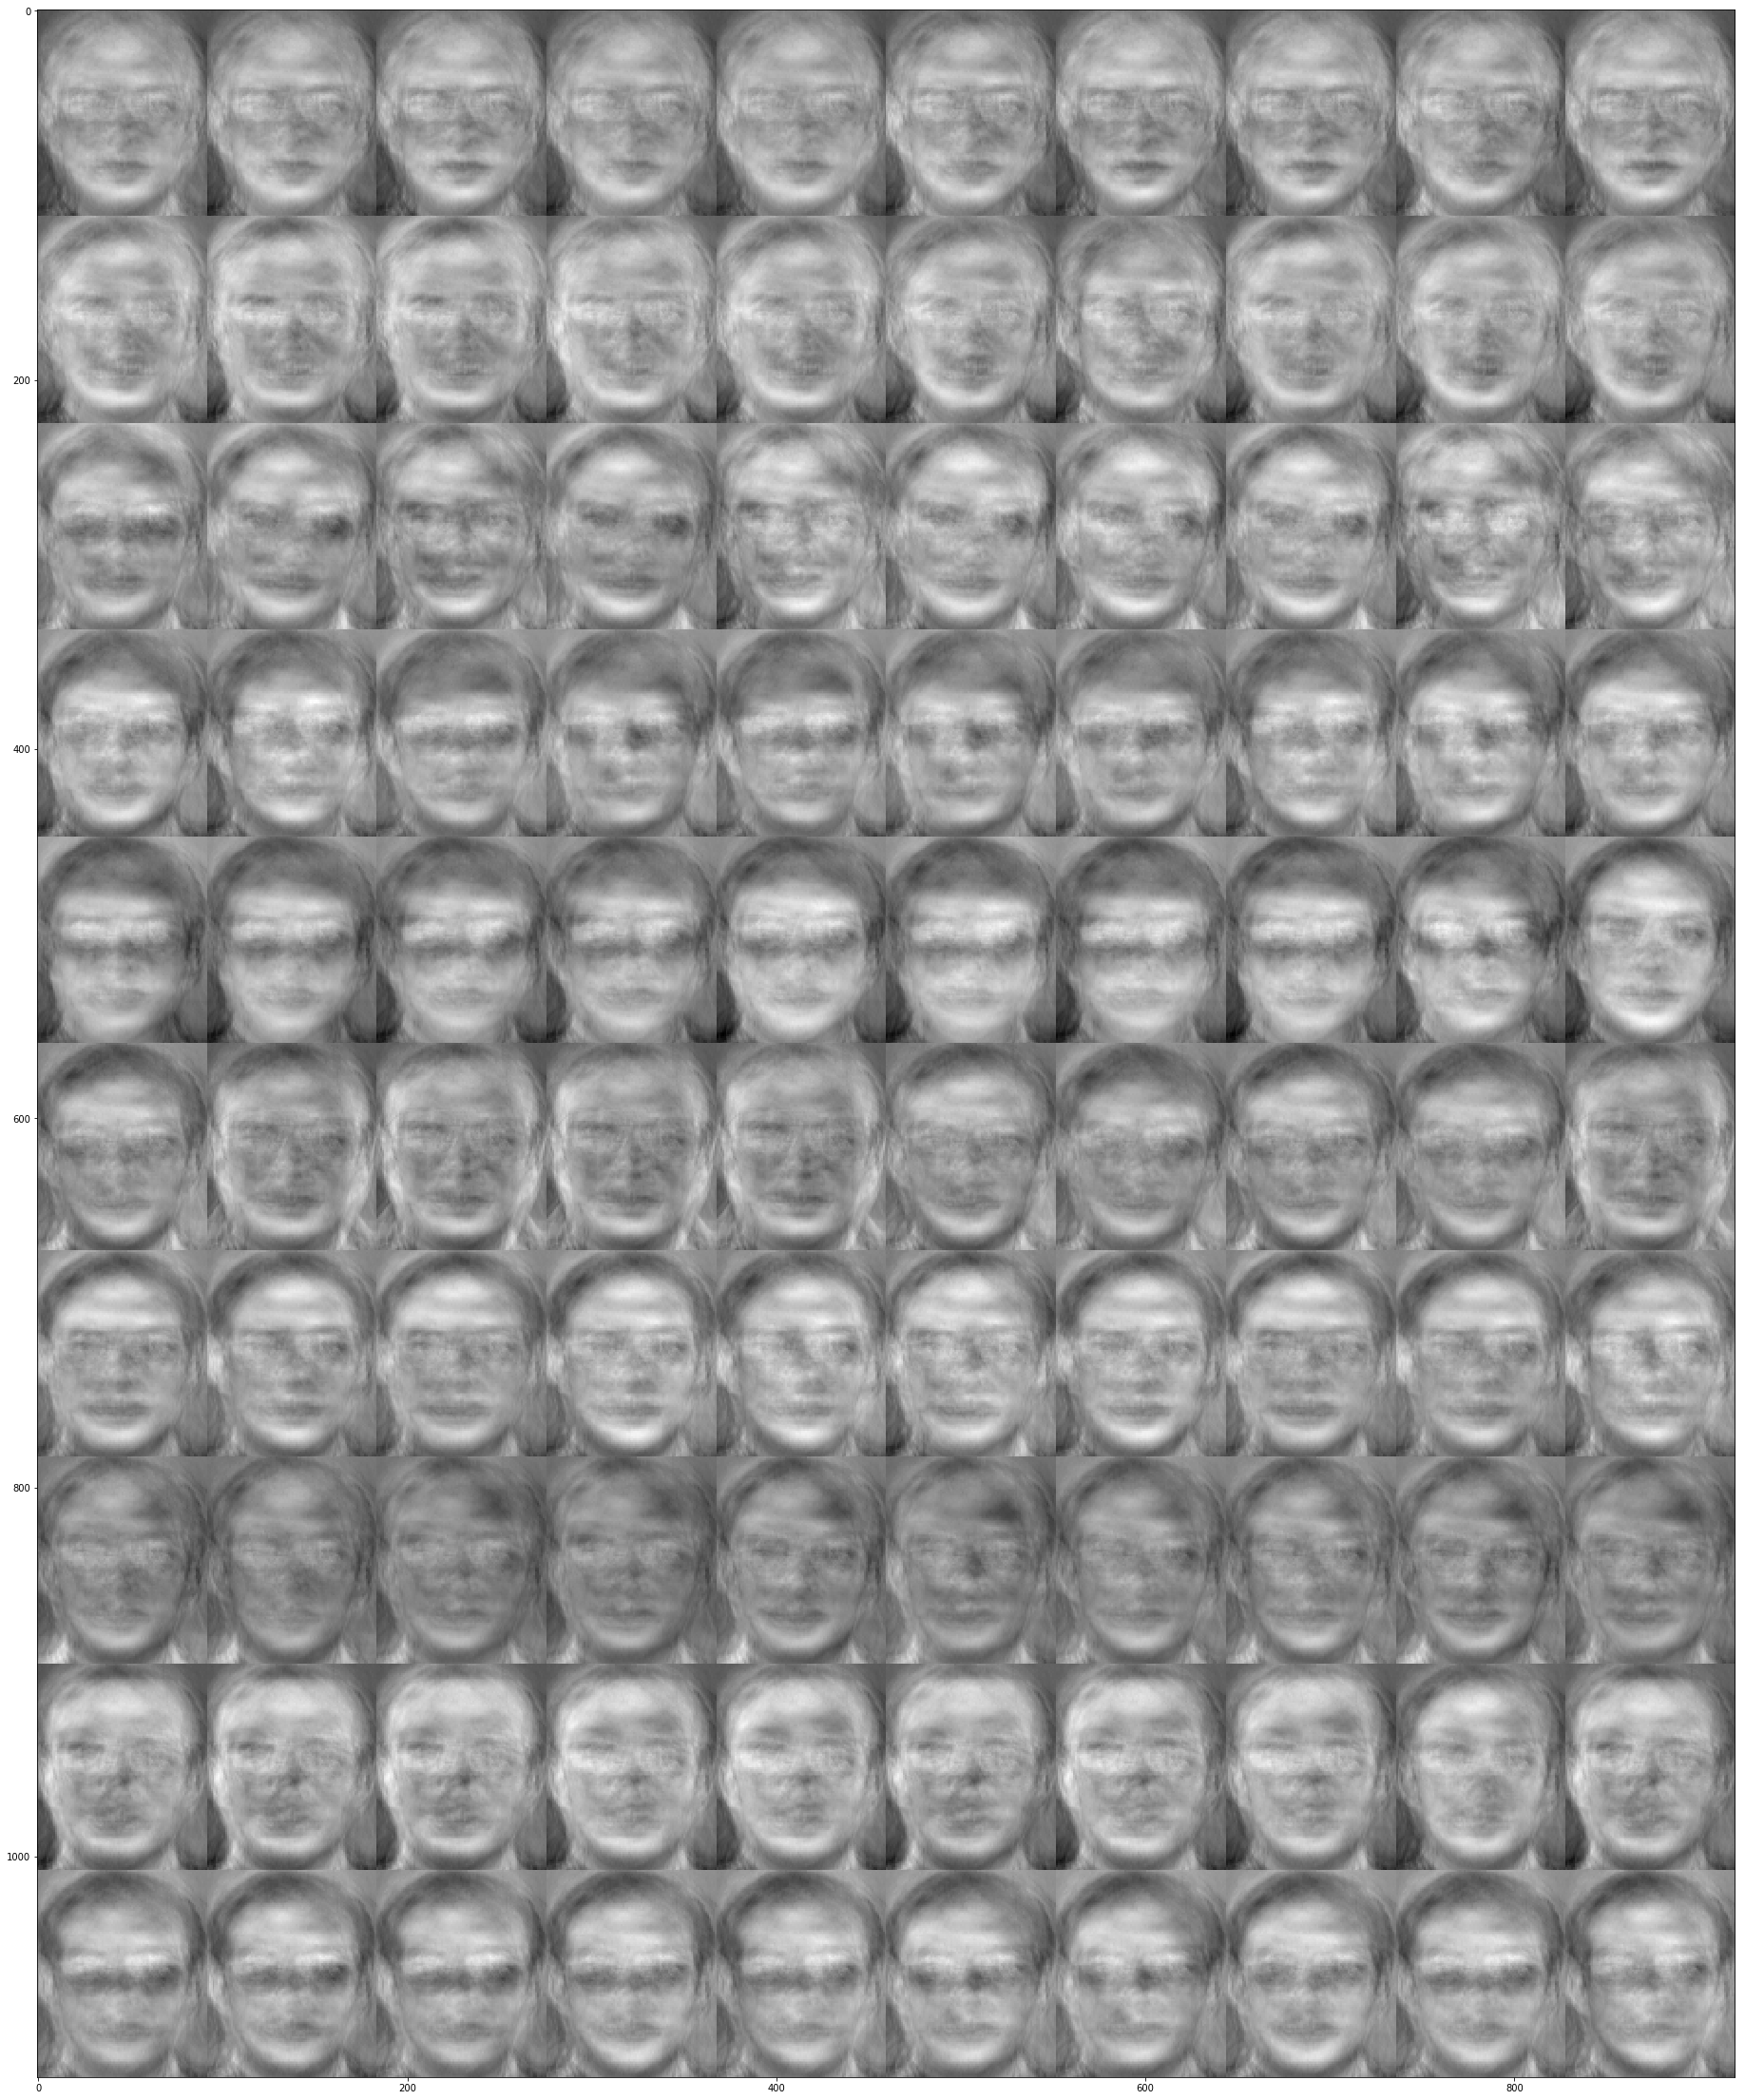

In [703]:
# random pick subject
random_faces = np.concatenate([
    att_faces_data[sj*10:(sj+1)*10] 
    for sj in np.random.randint(0,40, size=10)]
, axis=0)

showFaces(random_faces)
showFaces(np.matmul(
    np.matmul(random_faces, face_eigen), 
    face_eigen.T)
)